In [133]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [134]:
outdict = readinput("chem300.rms")

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [135]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [136]:
sitedensity = 2.292e-5; # Ag111
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [137]:
initialcondsliq = Dict(["proton"=>10.0^-4,
        "CO2"=>10.0^-3*10^6,
        "V"=>1.0,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
AVratio = 1e5;
initialcondssurf = Dict(["CO2X"=>0.4*sitedensity*AVratio,
        "CHO2X"=>0.1*sitedensity*AVratio,
        "CO2HX"=>0.1*sitedensity*AVratio,
        "OX"=>0.1*sitedensity*AVratio,
        "OCX"=>0.1*sitedensity*AVratio,
        "vacantX"=>0.1*sitedensity*AVratio,
        "CH2O2X"=>0.05*sitedensity*AVratio,
        "CHOX"=>0.04*sitedensity*AVratio,
        "CH2OX"=>0.01*sitedensity*AVratio,
        "A"=>1.0*AVratio,"T"=>300,"Phi"=>-1.5]);

In [138]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [139]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [140]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0e3), [inter], (pliq,pcat,pinter));


In [141]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-8);

In [142]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 7135-element Vector{Float64}:
    0.0
    4.786910423176204e-20
    9.573820846352407e-20
    1.4360731269528611e-19
    3.136209658750193e-19
    4.836346190547525e-19
    6.536482722344857e-19
    9.290855160451293e-19
    1.393701587359254e-18
    2.1962591531694716e-18
    ⋮
  879.5546091455969
  894.8998163040148
  910.2450234624328
  925.5902306208507
  940.9354377792686
  956.2806449376865
  971.6258520961044
  986.9710592545223
 1000.0
u: 7135-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 3.612374328324481e-148, 4.385132164362883e-19, 1.633795305695168e-19, 2.7428996724663614e-14  …  1.1203467421629118e-45, 1.8994249591181796e-72, 1.2800354014369318e-87, -3.879530191351059e-178, 1.3708129609046892e-77, 1.3213726871771316e-91, 1.5496805651867354e-69, 1.0657739381929874e-102, 7.799295861017468e

In [143]:
sol.retcode

ReturnCode.Success = 1

In [144]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [145]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [146]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

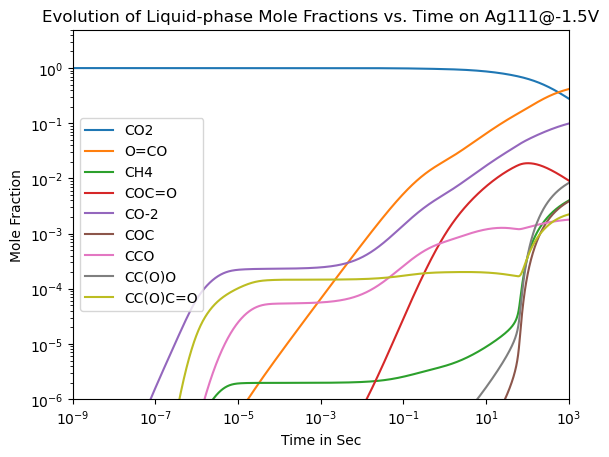

In [147]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-3, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-9, 1e3)
ylim(1e-6, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

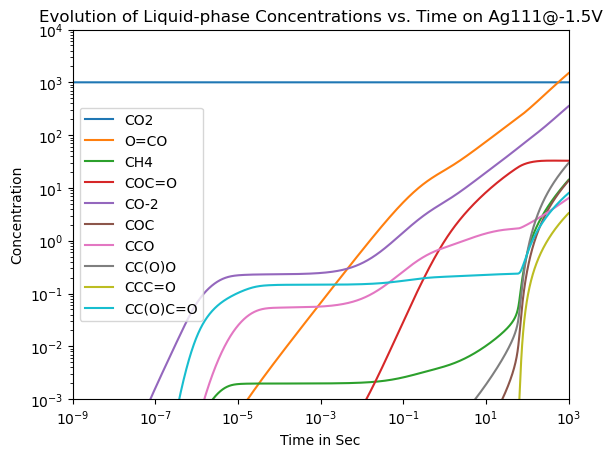

In [148]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-9, 1e3)
ylim(1e-3, 1e4)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

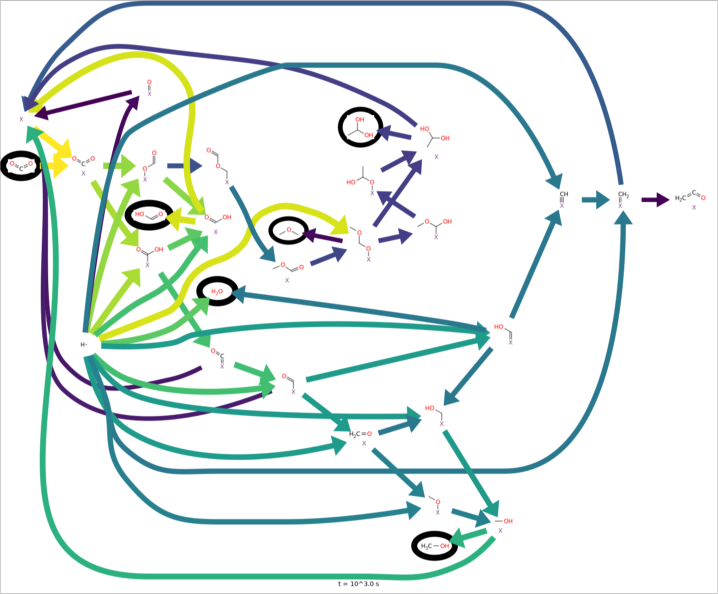

In [149]:
getfluxdiagram(ssys,1e3;speciesratetolerance=1e-6)

In [150]:
println(ssys.names)

In [151]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

In [152]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

In [203]:
rops(ssys, "O=CO", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 18 stored entries:
  [11   ]  =  -6.62794e-112
  [10253]  =  5.62284
  [10254]  =  8950.06
  [10255]  =  -8.57104e-20
  [10256]  =  -7.59582e-24
  [10265]  =  8.69249e-8
  [10268]  =  5.42172e-14
           ⋮
  [10310]  =  7.39712e-51
  [10352]  =  7.94894e-27
  [10540]  =  1.733e-29
  [10555]  =  6.69799e-34
  [10835]  =  1.03174e-24
  [10865]  =  5.4537e-26
  [10867]  =  1.78878e-45
  [10908]  =  1.48135e-12

In [190]:
function plotROP(bsol,name,t;N=0,tol=0.01)
    clf()
    rop = rops(bsol,name,t)
    inds = rop.nzind[reverse(sortperm(abs.(rop.nzval)))]
    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(rop[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(rop[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    xs = Array{Float64,1}(1:length(inds))
    barh(xs,reverse(rop[inds]))
    yticks(xs,reverse(getrxnstr.(bsol.domain.phase.reactions[inds])))
    xlabel("Production/Loss Rate mol/s")
    return
end

plotROP (generic function with 2 methods)

In [199]:
plotROP(ssys.sims[2], "CH2O2X",1;N=15,tol=0.0)

UndefVarError: UndefVarError: `getphasespecies` not defined

In [206]:
rops(ssys, "CH2O2X", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 528 stored entries:
  [47   ]  =  2.35221e10
  [48   ]  =  1.82944e6
  [49   ]  =  1.82944e6
  [50   ]  =  0.93615
  [53   ]  =  1.82944e6
  [54   ]  =  1.82944e6
  [56   ]  =  21.6762
           ⋮
  [10084]  =  5.29789e-29
  [10087]  =  6.68217e-37
  [10088]  =  1.51366e-30
  [10242]  =  1.87538e5
  [10243]  =  5.37857e5
  [10253]  =  -5.62284
  [10264]  =  -6.26487e-6
  [10266]  =  -4.38995e-6

In [207]:
rops(ssys, "O=CO", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 18 stored entries:
  [11   ]  =  -6.62794e-112
  [10253]  =  5.62284
  [10254]  =  8950.06
  [10255]  =  -8.57104e-20
  [10256]  =  -7.59582e-24
  [10265]  =  8.69249e-8
  [10268]  =  5.42172e-14
           ⋮
  [10310]  =  7.39712e-51
  [10352]  =  7.94894e-27
  [10540]  =  1.733e-29
  [10555]  =  6.69799e-34
  [10835]  =  1.03174e-24
  [10865]  =  5.4537e-26
  [10867]  =  1.78878e-45
  [10908]  =  1.48135e-12

In [194]:
ssys.sims[1].domain

ConstantTVDomain{IdealDiluteSolution{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}(IdealDiluteSolution{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
  name: String "liquid"
  species: Array{Species}((108,))
  reactions: Array{ElementaryReaction}((43,))
  solvent: Solvent
  stoichmatrix: SparseArrays.SparseMatrixCSC{Float64, Int64}
  Nrp: Array{Float64}((43,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  rxnarray: Array{Int64}((8, 43)) [7 7 … 7 15; 33 34 … 106 106; … ; 0 0 … 0 0; 0 0 … 0 0]
  veckinetics: Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}
  veckineticsinds: Array{Int64}((1,)) [43]
  vecthermo: ReactionMechanismSimulator.NASAvec{EmptyThermoUncertainty}
  otherreaction